In [863]:
import numpy as np 
import pandas as pd
from pandas import DataFrame as df
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Part A. Simulate Data

### draw exogenous variables

In [641]:
# Define True Parameters
alpha_1, alpha_2, alpha_3, alpha_4, alpha_5 = (4, 3, 4.5, 2, 3)
alpha_list = [alpha_1, alpha_2, alpha_3, alpha_4, alpha_5]
gamma, beta_bar, sigma_beta = (1.5, -1, 0.2)
omega_0, omega_1, omega_2, omega_3 = (4, 1, 1, 0.5)
sigma_xi, sigma_e = (1, 0.5)

In [642]:
# Define the length of the data
T = 100

In [710]:
# panel frame t X j 
t_list = []
j_list = []
for i in range(1,T+1):
    t_temp = list(np.full(5,i))
    j_temp = [k for k in range(1,6)]
    t_list = t_list + t_temp
    j_list = j_list + j_temp

# (1) Random Draw Part
# fix the seed to allow replication
np.random.seed(20220702)  #2, 7, 245787696, 20220702

# draw x
x_list = np.random.normal(1, 0.5, 5*T)

# draw z_1, z_2
z_1_list = np.random.normal(1, 0.5, 5*T)
z_2_list = np.random.normal(1, 0.5, 5*T)

# draw xi & e
xi_list = np.random.normal(0, 1, 5*T)
e_list = np.random.normal(0, 0.5, 5*T)

# construct a dataframe
df_master = df({"t": t_list, "j": j_list, "x": x_list, "z_1": z_1_list, "z_2": z_2_list, "xi": xi_list, "e": e_list})

### calculate optimal price (endogenize price)

In [711]:
# fix the random draw of nu
np.random.seed(2)
nu_perseon_1000 = np.random.normal(0,1,1000)

def share_partial_calculator(price_vector, work_data):
    for k in range(5):
        exp_list = []
        exp_sum = 0
        for k in range(5):
            x_k = work_data['x'].values[k]
            p_k = price_vector[k]
            xi_k = work_data['xi'].values[k]
            u_k_true = alpha_list[k] + gamma*x_k + beta_bar*p_k + xi_k + sigma_beta*p_k*nu_perseon_1000        
            exp_list.append(np.exp(u_k_true))
            exp_sum += np.exp(u_k_true)
        
        denominator = 1+exp_sum
        share_list = [(exp_list[j]/denominator).mean() for j in range(5)]
        partial_list = [((beta_bar + sigma_beta*nu_perseon_1000)*(exp_list[j]/denominator)*(1-(exp_list[j]/denominator))).mean() for j in range(5)]
        return np.array(share_list), np.array(partial_list)


## calculate price using fixed point algorithm 
price_list = []
for t in range(1,T+1):    
    work_data = df_master.loc[df_master['t'] == t]
    epsilon = 1e-14
    price_pre = np.array([4,4,4,4,4])
    mc_array = omega_0 + omega_1*work_data['x'].values + omega_2*work_data['z_1'].values + omega_3*work_data['z_2'].values + work_data['e'].values

    while True:
        # calculate share and partial derivative 
        share_array = share_partial_calculator(price_pre, work_data)[0]
        partial_array = share_partial_calculator(price_pre, work_data)[1]

        # calculate post price
        price_post = mc_array - share_array/partial_array

        # break or update
        if (abs(price_post - price_pre)).max() < epsilon:
            break
        else: 
            price_pre = price_post
            
    price_list = price_list + list(price_post)
    
df_master['price'] = price_list



## calculate associated market share
true_share_list = []
for t in range(1,T+1):    
    work_data = df_master.loc[df_master['t'] == t]
    true_share_temp = list(share_partial_calculator(work_data['price'].values, work_data)[0])
    true_share_list = true_share_list + true_share_temp
df_master['true_share'] = true_share_list


## calculate true delta
true_delta_list = []
for t in range(1,T+1):
    work_data = df_master.loc[df_master['t'] == t]
    true_delta_temp = []
    for k in range(5):
        x_k = work_data['x'].values[k]
        p_k = work_data['price'].values[k]
        xi_k = work_data['xi'].values[k]
        alpha_k = alpha_list[k]
        true_delta_k = alpha_k + gamma*x_k + beta_bar*p_k + xi_k
        true_delta_temp.append(true_delta_k)
    true_delta_list = true_delta_list + true_delta_temp
df_master['true_delta'] = true_delta_list 

# Part B. Demand Side Estimation

In [461]:
from sklearn.linear_model import LinearRegression
from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import linearmodels
from statsmodels.iolib.summary2 import summary_col
from scipy.optimize import minimize

In [712]:
# construct IV
df_avrg_x = df(df_master.groupby('t')['x'].mean())
df_avrg_z_1 = df(df_master.groupby('t')['z_1'].mean())
df_avrg_z_2 = df(df_master.groupby('t')['z_2'].mean())
df_avrg_x = df_avrg_x.rename(columns= {"x": "avrg_x"})
df_avrg_z_1 = df_avrg_z_1.rename(columns= {"z_1": "avrg_z_1"})
df_avrg_z_2 = df_avrg_z_2.rename(columns= {"z_2": "avrg_z_2"})
df_avrg_x = df_avrg_x.reset_index()
df_avrg_z_1 = df_avrg_z_1.reset_index()
df_avrg_z_2 = df_avrg_z_2.reset_index()

df_master = pd.merge(df_master, df_avrg_x, left_on= "t", right_on= "t")
df_master = pd.merge(df_master, df_avrg_z_1, left_on= "t", right_on= "t")
df_master = pd.merge(df_master, df_avrg_z_2, left_on= "t", right_on= "t")

df_master['IV2'] = (5*df_master['avrg_x'] - df_master['x'])/4
df_master['IV3'] = (5*df_master['avrg_z_1'] - df_master['z_1'])/4
df_master['IV4'] = (5*df_master['avrg_z_1'] - df_master['z_2'])/4

df_master['constant'] = np.ones(5*T)
df_master['firm2_dummy'] = np.where(df_master['j'] == 2, 1, 0)
df_master['firm3_dummy'] = np.where(df_master['j'] == 3, 1, 0)
df_master['firm4_dummy'] = np.where(df_master['j'] == 4, 1, 0)
df_master['firm5_dummy'] = np.where(df_master['j'] == 5, 1, 0)


In [713]:
def obj_function(sigma_beta, df_master):

    ############### Don't Change This Part #################
    # code serching for delta Fixed Point 
    # coming from HW3, so this part is correct
    epsilon = 1e-14
    delta_list = []
    for t in range(1, T+1):
        work_data = df_master.loc[df_master['t'] == t]

        # 1. set the initial vector of theta (name it delta_pre)
        share_outer = 1 - work_data['true_share'].sum()
        delta_pre = np.log(work_data['true_share'].values / share_outer) 
        
        # 2. update delta by searching for the fixed point
        #    calculate model predicted share with MC integration    
        # fix the seed for random nu
        np.random.seed(3)
        nu_draw = np.random.normal(0, 1, 200)
        while True:    
            # 2-1. calculate denominator
            exp_common = 0
            for j in range(5):
                delta_j = delta_pre[j]
                p_j = work_data['price'].values[j]
                exp_j = np.exp(delta_j + sigma_beta*p_j*nu_draw)     ##### sigma beta matters here #####
                exp_common += exp_j
            denominator_common = 1+ exp_common
                
            # 2-2. calculate market share for 10 products 
            share_list_temp = []
            for j in range(5):
                delta_j = delta_pre[j]
                p_j = work_data['price'].values[j]
                exp_j = np.exp(delta_j + sigma_beta*p_j*nu_draw)
                s_j = (exp_j/denominator_common).mean()
                share_list_temp.append(s_j)

            # 2-3. update delta
            share_list_array = np.array(share_list_temp)
            delta_post = delta_pre + np.log(work_data['true_share'].values / share_list_array) 

            # 3. Break Condition and Update
            if (abs(delta_post - delta_pre)).max() < epsilon:
                break
            else: 
                delta_pre = delta_post

        delta_list_temp = list(delta_pre)
        delta_list = delta_list + delta_list_temp
    
    df_master['delta_FXP'] = delta_list 
    #########################################################




    #step 2: 2SLS
    IV_result = IV2SLS(dependent=df_master['delta_FXP'],
                    exog = df_master[['constant', 'firm2_dummy', 'firm3_dummy', 'firm4_dummy', 'firm5_dummy', 'x']],
                    endog = df_master['price'],
                    instruments=df_master[['z_1','z_2','IV2']]).fit()

    alpha_1_hat, firm_2_dummy, firm_3_dummy, firm_4_dummy, firm_5_dummy = IV_result.params[:5]
    alpha_2_hat = alpha_1_hat + firm_2_dummy
    alpha_3_hat = alpha_1_hat + firm_3_dummy
    alpha_4_hat = alpha_1_hat + firm_4_dummy
    alpha_5_hat = alpha_1_hat + firm_5_dummy
    alpha_hat_list = [alpha_1_hat, alpha_2_hat, alpha_3_hat, alpha_4_hat, alpha_5_hat]
    gamma_hat = IV_result.params[5]
    beta_bar_hat = IV_result.params[6]

    xi_list = []
    for t in range(1, T+1):
        work_data = df_master.loc[df_master['t'] == t]
        xi_temp = []
        for k in range(5):
            delta_FXP_k = df_master['delta_FXP'].values[k]
            alpha_k = alpha_hat_list[k]
            x_k = df_master['x'].values[k]
            price_k = df_master['price'].values[k]
            xi_k = delta_FXP_k - alpha_k - gamma_hat*x_k - beta_bar_hat*price_k
            xi_temp.append(xi_k)
        xi_list = xi_list + xi_temp

    xi_array = np.array(xi_list)
    
    
    #step 3: GMM
    #sample analogy
    g1_bar = (xi_array * df_master['z_1'].values).mean()
    g2_bar = (xi_array * df_master['z_2'].values).mean()
    g3_bar = (xi_array * df_master['IV2'].values).mean()
    g4_bar = ((xi_array * df_master['z_1'].values)**2).mean() 
    g5_bar = ((xi_array * df_master['z_2'].values)**2).mean()
    g6_bar = ((xi_array * df_master['IV2'].values)**2).mean()

    g_bar_array = np.array([g1_bar, g2_bar, g3_bar, g4_bar, g5_bar, g6_bar])
    #g_bar_array = np.array([g1_bar, g2_bar, g4_bar, g5_bar])

    return g_bar_array@g_bar_array

In [714]:
GMM_result = minimize(obj_function, 0.5, args = (df_master), bounds = ((0,5),), method='Nelder-Mead', options={'maxiter':200, 'disp': True})

Optimization terminated successfully.
         Current function value: 7.887872
         Iterations: 14
         Function evaluations: 28


In [715]:
sigma_beta_hat = GMM_result.x[0]
############### Don't Change This Part #################
# code serching for delta Fixed Point 
# coming from HW3, so this part is correct
epsilon = 1e-14
delta_list = []
for t in range(1, T+1):
    work_data = df_master.loc[df_master['t'] == t]

    # 1. set the initial vector of theta (name it delta_pre)
    share_outer = 1 - work_data['true_share'].sum()
    delta_pre = np.log(work_data['true_share'].values / share_outer) 
    
    # 2. update delta by searching for the fixed point
    #    calculate model predicted share with MC integration    
    # fix the seed for random nu
    np.random.seed(3)
    nu_draw = np.random.normal(0, 1, 200)
    while True:    
        # 2-1. calculate denominator
        exp_common = 0
        for j in range(5):
            delta_j = delta_pre[j]
            p_j = work_data['price'].values[j]
            exp_j = np.exp(delta_j + sigma_beta_hat*p_j*nu_draw)     ##### sigma beta matters here #####
            exp_common += exp_j
        denominator_common = 1+ exp_common
            
        # 2-2. calculate market share for 10 products 
        share_list_temp = []
        for j in range(5):
            delta_j = delta_pre[j]
            p_j = work_data['price'].values[j]
            exp_j = np.exp(delta_j + sigma_beta_hat*p_j*nu_draw)
            s_j = (exp_j/denominator_common).mean()
            share_list_temp.append(s_j)

        # 2-3. update delta
        share_list_array = np.array(share_list_temp)
        delta_post = delta_pre + np.log(work_data['true_share'].values / share_list_array) 

        # 3. Break Condition and Update
        if (abs(delta_post - delta_pre)).max() < epsilon:
            break
        else: 
            delta_pre = delta_post

    delta_list_temp = list(delta_pre)
    delta_list = delta_list + delta_list_temp

df_master['delta_FXP'] = delta_list 
#########################################################




#step 2: 2SLS
IV_result = IV2SLS(dependent=df_master['delta_FXP'],
                exog = df_master[['constant', 'firm2_dummy', 'firm3_dummy', 'firm4_dummy', 'firm5_dummy', 'x']],
                endog = df_master['price'],
                instruments=df_master[['z_1','z_2','IV2']]).fit()

alpha_1_hat, firm_2_dummy, firm_3_dummy, firm_4_dummy, firm_5_dummy = IV_result.params[:5]
alpha_2_hat = alpha_1_hat + firm_2_dummy
alpha_3_hat = alpha_1_hat + firm_3_dummy
alpha_4_hat = alpha_1_hat + firm_4_dummy
alpha_5_hat = alpha_1_hat + firm_5_dummy
gamma_hat = IV_result.params[5]
beta_bar_hat = IV_result.params[6]

print("GMM estimate for alpha_1: ", alpha_1_hat)
print("GMM estimate for alpha_2: ", alpha_2_hat)
print("GMM estimate for alpha_3: ", alpha_3_hat)
print("GMM estimate for alpha_4: ", alpha_4_hat)
print("GMM estimate for alpha_5: ", alpha_5_hat)
print("GMM estimate for gamma: ", gamma_hat)
print("GMM estimate for beta_bar: ", beta_bar_hat)
print("GMM estimate for sigma_beta: ", sigma_beta_hat)

GMM estimate for alpha_1:  4.427154928289852
GMM estimate for alpha_2:  3.633556882859601
GMM estimate for alpha_3:  5.037803792394429
GMM estimate for alpha_4:  2.4005726552860995
GMM estimate for alpha_5:  3.570424446084255
GMM estimate for gamma:  1.814013352154717
GMM estimate for beta_bar:  -1.1150626597026179
GMM estimate for sigma_beta:  0.22910156249999974


# Part C. Supply Side Estimation

In [716]:
# compute the marginal cost
df_master['mc_hat'] = df_master['price'].values + 1/(beta_bar_hat*(1-df_master['true_share'].values))

In [717]:
# do the OLS
mc_regression = sm.OLS(df_master['mc_hat'], df_master[['constant', 'x', 'z_1', 'z_2']]).fit()
omega_0_hat = mc_regression.params[0]
omega_1_hat = mc_regression.params[1]
omega_2_hat = mc_regression.params[2]
omega_3_hat = mc_regression.params[3]

print("OLS estimate for omega_0: ", omega_0_hat)
print("OLS estimate for omega_1: ", omega_1_hat)
print("OLS estimate for omega_2: ", omega_2_hat)
print("OLS estimate for omega_3: ", omega_3_hat)


OLS estimate for omega_0:  4.443804151285334
OLS estimate for omega_1:  1.057734481890185
OLS estimate for omega_2:  1.027430405897602
OLS estimate for omega_3:  0.3506671992797803


# Part D. Counterfactual Experiments

### (1) Brand Value Measurement

In [718]:
# STEP1 calculate xi_hat & e_hat
df_alpha = df({'j': [1,2,3,4,5], 'alpha_hat': [alpha_1_hat, alpha_2_hat, alpha_3_hat, alpha_4_hat, alpha_5_hat]})
df_master = pd.merge(df_master, df_alpha, left_on='j', right_on='j')
df_master['xi_hat'] = df_master['delta_FXP'].values - df_master['alpha_hat'].values - gamma_hat*df_master['x'].values - beta_bar_hat*df_master['price'].values
df_master['e_hat'] = df_master['mc_hat'].values - omega_0_hat - omega_1_hat*df_master['x'].values - omega_2_hat*df_master['z_1'].values - omega_3_hat*df_master['z_2'].values

xi_hat_1 = df_master.loc[df_master['j'] == 1]['xi_hat'].values
xi_hat_2 = df_master.loc[df_master['j'] == 2]['xi_hat'].values
xi_hat_3 = df_master.loc[df_master['j'] == 3]['xi_hat'].values
xi_hat_4 = df_master.loc[df_master['j'] == 4]['xi_hat'].values
xi_hat_5 = df_master.loc[df_master['j'] == 5]['xi_hat'].values

e_hat_1 = df_master.loc[df_master['j'] == 1]['e_hat'].values
e_hat_2 = df_master.loc[df_master['j'] == 2]['e_hat'].values
e_hat_3 = df_master.loc[df_master['j'] == 3]['e_hat'].values
e_hat_4 = df_master.loc[df_master['j'] == 4]['e_hat'].values
e_hat_5 = df_master.loc[df_master['j'] == 5]['e_hat'].values

In [719]:
alpha_hat_list = [alpha_1_hat, alpha_2_hat, alpha_3_hat, alpha_4_hat, alpha_5_hat]


def share_partial_calculator_baseline(price_vector, work_data):
    exp_list = []
    exp_sum = 0
    for k in range(5):
        x_k = work_data['x'].values[k]
        p_k = price_vector[k]
        xi_k = work_data['xi'].values[k]
        u_k_true = alpha_hat_list[k] + gamma_hat*x_k + beta_bar_hat*p_k + xi_k + sigma_beta_hat*p_k*nu_perseon_1000        
        exp_list.append(np.exp(u_k_true))
        exp_sum += np.exp(u_k_true)
    
    denominator = 1+exp_sum
    share_list = [(exp_list[j]/denominator).mean() for j in range(5)]
    partial_list = [((beta_bar_hat + sigma_beta_hat*nu_perseon_1000)*(exp_list[j]/denominator)*(1-(exp_list[j]/denominator))).mean() for j in range(5)]
    return np.array(share_list), np.array(partial_list)


def share_partial_calculator_counterfactual(price_vector, work_data, j):   #j: 0,1,2,3,4
    alpha_hat_list_prime = alpha_hat_list.copy()
    alpha_hat_list_prime[j] = 0

    exp_list = []
    exp_sum = 0
    for k in range(5):
        x_k = work_data['x'].values[k]
        p_k = price_vector[k]
        xi_k = work_data['xi'].values[k]
        u_k_true = alpha_hat_list_prime[k] + gamma_hat*x_k + beta_bar_hat*p_k + xi_k + sigma_beta_hat*p_k*nu_perseon_1000        
        exp_list.append(np.exp(u_k_true))
        exp_sum += np.exp(u_k_true)
    
    denominator = 1+exp_sum
    share_list = [(exp_list[j]/denominator).mean() for j in range(5)]
    partial_list = [((beta_bar_hat + sigma_beta_hat*nu_perseon_1000)*(exp_list[j]/denominator)*(1-(exp_list[j]/denominator))).mean() for j in range(5)]
    return np.array(share_list), np.array(partial_list)

In [720]:
def counterfactual_pi(j, t):
    # STEP2&3 calculate the expected profit change
    work_data = df_master.loc[df_master['t'] == t]


    delta_pi_j = []
    eqm_price_BL = []
    eqm_price_CF = []
    R = 100
    for r in range(R):
        # randomly draw xi and e 
        xi_1_random = random.sample(list(xi_hat_1), 1)[0]
        xi_2_random = random.sample(list(xi_hat_2), 1)[0]
        xi_3_random = random.sample(list(xi_hat_3), 1)[0]
        xi_4_random = random.sample(list(xi_hat_4), 1)[0]
        xi_5_random = random.sample(list(xi_hat_5), 1)[0]

        e_1_random = random.sample(list(e_hat_1), 1)[0]
        e_2_random = random.sample(list(e_hat_2), 1)[0]
        e_3_random = random.sample(list(e_hat_3), 1)[0]
        e_4_random = random.sample(list(e_hat_4), 1)[0]
        e_5_random = random.sample(list(e_hat_5), 1)[0]

        xi_random_array = np.array([xi_1_random, xi_2_random, xi_3_random, xi_4_random, xi_5_random])
        e_random_array = np.array([e_1_random, e_2_random, e_3_random, e_4_random, e_5_random])
        pd.set_option('mode.chained_assignment',  None)
        work_data['xi'] = xi_random_array
        work_data['e'] = e_random_array

        epsilon = 1e-14
        price_pre_baseline = np.array([4,4,4,4,4])
        price_pre_counterfactual = np.array([4,4,4,4,4])
        mc_array = omega_0_hat + omega_1_hat*work_data['x'].values + omega_2_hat*work_data['z_1'].values + omega_3_hat*work_data['z_2'].values + work_data['e'].values

        # (1) calculate baseline price: p^*
        count = 0
        while (count <= 50):
            # calculate share and partial derivative
            share_array_baseline = share_partial_calculator_baseline(price_pre_baseline, work_data)[0]
            partial_array_baseline = share_partial_calculator_baseline(price_pre_baseline, work_data)[1]

            # calculate post price
            price_post_baseline = mc_array - share_array_baseline/partial_array_baseline

            # break or update
            if (abs(price_post_baseline - price_pre_baseline)).max() < epsilon:
                break
            else: 
                price_pre_baseline = price_post_baseline

            count += 1

        # (2) calculate counterfactual price: p^**
        count = 0
        while (count <= 50):
            # calculate share and partial derivative
            share_array_counterfactual = share_partial_calculator_counterfactual(price_pre_counterfactual, work_data, j)[0]
            partial_array_counterfactual = share_partial_calculator_counterfactual(price_pre_counterfactual, work_data, j)[1]

            # calculate post price
            price_post_counterfactual = mc_array - share_array_counterfactual/partial_array_counterfactual

            # break or update
            if (abs(price_post_counterfactual - price_pre_counterfactual)).max() < epsilon:
                break
            else: 
                price_pre_counterfactual = price_post_counterfactual

            count += 1

        
        eqm_price_baseline = price_post_baseline
        eqm_share_baseline = share_partial_calculator_baseline(eqm_price_baseline, work_data)[0]
        eqm_pi_baseline = (eqm_price_baseline - mc_array)*eqm_share_baseline

        eqm_price_counterfactual = price_post_counterfactual
        eqm_share_counterfactual = share_partial_calculator_counterfactual(eqm_price_counterfactual, work_data, j)[0]
        eqm_pi_counterfactual = (eqm_price_counterfactual - mc_array)*eqm_share_counterfactual

        eqm_price_BL.append(eqm_price_baseline)
        eqm_price_CF.append(eqm_price_counterfactual)
        delta_pi_j.append((eqm_pi_counterfactual - eqm_pi_baseline)[j])


    return np.array(delta_pi_j).mean(), np.array(eqm_price_BL).mean(0), np.array(eqm_price_CF).mean(0)             

In [721]:
def outcome_calculator_pi(j):

    T = 20
    avrg_delta_pi_sum = 0
    price_before_vec = []
    price_after_vec = []
    for t in range(1, T+1):
        avrg_delta_pi, price_before, price_after = counterfactual_pi(j, t)
        avrg_delta_pi_sum += avrg_delta_pi
        price_before_vec.append(price_before)
        price_after_vec.append(price_after)

    return -avrg_delta_pi_sum/T, np.array(price_before_vec).mean(0), np.array(price_after_vec).mean(0)


In [722]:
product5_brand_value, product5_pre_price, product5_post_price = outcome_calculator_pi(4)
product4_brand_value, product4_pre_price, product4_post_price = outcome_calculator_pi(3)
product3_brand_value, product3_pre_price, product3_post_price = outcome_calculator_pi(2)
product2_brand_value, product2_pre_price, product2_post_price = outcome_calculator_pi(1)
product1_brand_value, product1_pre_price, product1_post_price = outcome_calculator_pi(0)

In [723]:
print("Brand Value of Firm 1: ", product1_brand_value)
print("Brand Value of Firm 2: ", product2_brand_value)
print("Brand Value of Firm 3: ", product3_brand_value)
print("Brand Value of Firm 4: ", product4_brand_value)
print("Brand Value of Firm 5: ", product5_brand_value)

Brand Value of Firm 1:  0.10763541195956221
Brand Value of Firm 2:  0.06429564231771082
Brand Value of Firm 3:  0.188268403565025
Brand Value of Firm 4:  0.018154916728188204
Brand Value of Firm 5:  0.04972323959187671


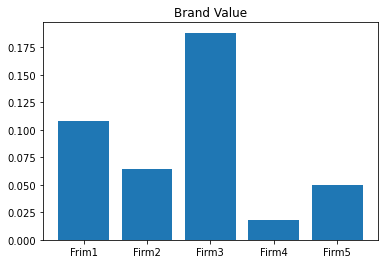

In [724]:
b_value = [product1_brand_value, product2_brand_value, product3_brand_value, product4_brand_value, product5_brand_value]
x_tick = ["Frim1", "Firm2", "Firm3", "Firm4", "Firm5"]
plt.bar(x_tick, b_value)
plt.title("Brand Value")
plt.show()

In [902]:
print(100*(product1_post_price-product1_pre_price)/product1_pre_price)
print(100*(product2_post_price-product2_pre_price)/product2_pre_price)
print(100*(product3_post_price-product3_pre_price)/product3_pre_price)
print(100*(product4_post_price-product4_pre_price)/product4_pre_price)
print(100*(product5_post_price-product5_pre_price)/product5_pre_price)

[-1.87573682  0.71372366  1.33606945  0.45426546  0.64129057]
[ 0.53170212 -1.12206159  0.78357877  0.26115759  0.36562278]
[ 1.68678082  1.310908   -3.18772293  0.79674109  1.08802876]
[ 0.15610392  0.12556989  0.2200521  -0.33972462  0.10737512]
[ 0.44100282  0.3125666   0.59780749  0.18031071 -0.91512679]


In [737]:
def CW_after(xi, e, work_data, j):
    '''
    xi: sampled 5X1 vector of xi 
    e : sampled 5X1 vector of e
    work_data: certain market t's data
    j : counterfactual product
    '''
    alpha_hat_list_prime = alpha_hat_list.copy()
    alpha_hat_list_prime[j] = 0

    work_data_temp = work_data.copy()
    work_data_temp['xi'] = xi
    work_data_temp['e'] = e
    
    price_pre_counterfactual = np.array([4,4,4,4,4])
    mc_array = omega_0_hat + omega_1_hat*work_data_temp['x'].values + omega_2_hat*work_data_temp['z_1'].values + omega_3_hat*work_data_temp['z_2'].values + work_data_temp['e'].values
    
    # (1) calculate eqm price under xi and e
    count = 0
    while (count <= 50):
        # calculate share and partial derivative
        share_array_counterfactual = share_partial_calculator_counterfactual(price_pre_counterfactual, work_data_temp, j)[0]
        partial_array_counterfactual = share_partial_calculator_counterfactual(price_pre_counterfactual, work_data_temp, j)[1]

        # calculate post price
        price_post_counterfactual = mc_array - share_array_counterfactual/partial_array_counterfactual

        # break or update
        if (abs(price_post_counterfactual - price_pre_counterfactual)).max() < epsilon:
            break
        else: 
            price_pre_counterfactual = price_post_counterfactual

        count += 1

    eqm_price = price_post_counterfactual
    
    # (2) calculate exponential sum
    exp_sum = 0
    for k in range(5):
        x_k = work_data_temp['x'].values[k]
        p_k = eqm_price[k]
        xi_k = work_data_temp['xi'].values[k]
        u_k_true = alpha_hat_list_prime[k] + gamma_hat*x_k + beta_bar_hat*p_k + xi_k + sigma_beta_hat*p_k*nu_perseon_1000        
        exp_sum += np.exp(u_k_true)
    
    # (3) calculate the average
    numerator = np.log(1+exp_sum)
    denominator = beta_bar_hat + sigma_beta_hat*nu_perseon_1000
    CW_after = -(numerator/denominator).mean()

    return CW_after
    

In [738]:
def CW_before(xi, e, work_data):
    '''
    xi: sampled 5X1 vector of xi 
    e : sampled 5X1 vector of e
    work_data: certain market t's data
    '''
    alpha_hat_list_prime = alpha_hat_list.copy()

    work_data_temp = work_data.copy()
    work_data_temp['xi'] = xi
    work_data_temp['e'] = e
    
    price_pre_baseline = np.array([4,4,4,4,4])
    mc_array = omega_0_hat + omega_1_hat*work_data_temp['x'].values + omega_2_hat*work_data_temp['z_1'].values + omega_3_hat*work_data_temp['z_2'].values + work_data_temp['e'].values
    
    # (1) calculate eqm price under xi and e
    count = 0
    while (count <= 50):
        # calculate share and partial derivative
        share_array_baseline = share_partial_calculator_baseline(price_pre_baseline, work_data_temp)[0]
        partial_array_baseline = share_partial_calculator_baseline(price_pre_baseline, work_data_temp)[1]

        # calculate post price
        price_post_baseline = mc_array - share_array_baseline/partial_array_baseline

        # break or update
        if (abs(price_post_baseline - price_pre_baseline)).max() < epsilon:
            break
        else: 
            price_pre_baseline = price_post_baseline

        count += 1

    eqm_price = price_post_baseline
    
    # (2) calculate exponential sum
    exp_sum = 0
    for k in range(5):
        x_k = work_data_temp['x'].values[k]
        p_k = eqm_price[k]
        xi_k = work_data_temp['xi'].values[k]
        u_k_true = alpha_hat_list_prime[k] + gamma_hat*x_k + beta_bar_hat*p_k + xi_k + sigma_beta_hat*p_k*nu_perseon_1000        
        exp_sum += np.exp(u_k_true)
    
    # (3) calculate the average
    numerator = np.log(1+exp_sum)
    denominator = beta_bar_hat + sigma_beta_hat*nu_perseon_1000
    CW_before = -(numerator/denominator).mean()

    return CW_before
    

In [742]:
def CW_change(j,t):
    work_data = df_master.loc[df_master['t'] == t]

    CW_delta = 0
    R = 100
    for r in range(R):
        # randomly draw xi and e 
        xi_1_random = random.sample(list(xi_hat_1), 1)[0]
        xi_2_random = random.sample(list(xi_hat_2), 1)[0]
        xi_3_random = random.sample(list(xi_hat_3), 1)[0]
        xi_4_random = random.sample(list(xi_hat_4), 1)[0]
        xi_5_random = random.sample(list(xi_hat_5), 1)[0]

        e_1_random = random.sample(list(e_hat_1), 1)[0]
        e_2_random = random.sample(list(e_hat_2), 1)[0]
        e_3_random = random.sample(list(e_hat_3), 1)[0]
        e_4_random = random.sample(list(e_hat_4), 1)[0]
        e_5_random = random.sample(list(e_hat_5), 1)[0]

        xi_random_array = np.array([xi_1_random, xi_2_random, xi_3_random, xi_4_random, xi_5_random])
        e_random_array = np.array([e_1_random, e_2_random, e_3_random, e_4_random, e_5_random])
        pd.set_option('mode.chained_assignment',  None)
        
        CW_post = CW_after(xi_random_array, e_random_array, work_data, j)
        CW_pre = CW_before(xi_random_array, e_random_array, work_data)

        CW_delta += (CW_post - CW_pre)

    return CW_delta/R

In [743]:
def CW_change_calculator(j):
    CW_change_list = [CW_change(j, t) for t in range(1,21)]
    return np.array(CW_change_list).mean()


In [744]:
CW_change_from_product1 = CW_change_calculator(0)
CW_change_from_product2 = CW_change_calculator(1)
CW_change_from_product3 = CW_change_calculator(2)
CW_change_from_product4 = CW_change_calculator(3)
CW_change_from_product5 = CW_change_calculator(4)

In [745]:
print("Welfare change from killing product 1's BV: ", CW_change_from_product1)
print("Welfare change from killing product 2's BV: ", CW_change_from_product2)
print("Welfare change from killing product 3's BV: ", CW_change_from_product3)
print("Welfare change from killing product 4's BV: ", CW_change_from_product4)
print("Welfare change from killing product 5's BV: ", CW_change_from_product5)

Welfare change from killing product 1's BV:  -0.13330195734587252
Welfare change from killing product 2's BV:  -0.08253585808949895
Welfare change from killing product 3's BV:  -0.22004581497287895
Welfare change from killing product 4's BV:  -0.02366081500115812
Welfare change from killing product 5's BV:  -0.06166344159834476


### (2) Merger

In [746]:
def cross_elasticity(price_vector, work_data):
    exp_list = []
    exp_sum = 0
    for k in range(5):
        x_k = work_data['x'].values[k]
        p_k = price_vector[k]
        xi_k = work_data['xi'].values[k]
        u_k_true = alpha_hat_list[k] + gamma_hat*x_k + beta_bar_hat*p_k + xi_k + sigma_beta_hat*p_k*nu_perseon_1000        
        exp_list.append(np.exp(u_k_true))
        exp_sum += np.exp(u_k_true)
    
    denominator = 1+exp_sum
    cross_elasticity = -((beta_bar_hat + sigma_beta_hat*nu_perseon_1000)*(exp_list[0]/denominator)*(exp_list[1]/denominator)).mean()
    
    return cross_elasticity


def cross_elasticity13(price_vector, work_data):
    exp_list = []
    exp_sum = 0
    for k in range(5):
        x_k = work_data['x'].values[k]
        p_k = price_vector[k]
        xi_k = work_data['xi'].values[k]
        u_k_true = alpha_hat_list[k] + gamma_hat*x_k + beta_bar_hat*p_k + xi_k + sigma_beta_hat*p_k*nu_perseon_1000        
        exp_list.append(np.exp(u_k_true))
        exp_sum += np.exp(u_k_true)
    
    denominator = 1+exp_sum
    cross_elasticity = -((beta_bar_hat + sigma_beta_hat*nu_perseon_1000)*(exp_list[0]/denominator)*(exp_list[2]/denominator)).mean()
    
    return cross_elasticity

In [747]:
def merge_pi12(t):
    # STEP2&3 calculate the expected profit change
    work_data = df_master.loc[df_master['t'] == t]

    delta_pi = []
    eqm_price_before = []
    eqm_price_after = []
    
    R = 100
    for r in range(R):    
        xi_1_random = random.sample(list(xi_hat_1), 1)[0]
        xi_2_random = random.sample(list(xi_hat_2), 1)[0]
        xi_3_random = random.sample(list(xi_hat_3), 1)[0]
        xi_4_random = random.sample(list(xi_hat_4), 1)[0]
        xi_5_random = random.sample(list(xi_hat_5), 1)[0]

        e_1_random = random.sample(list(e_hat_1), 1)[0]
        e_2_random = random.sample(list(e_hat_2), 1)[0]
        e_3_random = random.sample(list(e_hat_3), 1)[0]
        e_4_random = random.sample(list(e_hat_4), 1)[0]
        e_5_random = random.sample(list(e_hat_5), 1)[0]

        xi_random_array = np.array([xi_1_random, xi_2_random, xi_3_random, xi_4_random, xi_5_random])
        e_random_array = np.array([e_1_random, e_2_random, e_3_random, e_4_random, e_5_random])
        pd.set_option('mode.chained_assignment',  None)
        work_data['xi'] = xi_random_array
        work_data['e'] = e_random_array

        epsilon = 1e-14
        price_pre_baseline = np.array([4,4,4,4,4])
        price_pre_counterfactual = np.array([4,4,4,4,4])
        mc_array = omega_0_hat + omega_1_hat*work_data['x'].values + omega_2_hat*work_data['z_1'].values + omega_3_hat*work_data['z_2'].values + work_data['e'].values


        # (1) calculate baseline price: p^*
        count = 0
        while (count <= 50):
            # calculate share and partial derivative
            share_array_baseline = share_partial_calculator_baseline(price_pre_baseline, work_data)[0]
            partial_array_baseline = share_partial_calculator_baseline(price_pre_baseline, work_data)[1]

            # calculate post price
            price_post_baseline = mc_array - share_array_baseline/partial_array_baseline

            # break or update
            if (abs(price_post_baseline - price_pre_baseline)).max() < epsilon:
                break
            else: 
                price_pre_baseline = price_post_baseline

            count += 1

        # (2) calculate post merge price: p^**
        count = 0
        while (count <= 50):
            # calculate share and partial derivative
            share_array_counterfactual = share_partial_calculator_baseline(price_pre_counterfactual, work_data)[0]
            partial_array_counterfactual = share_partial_calculator_baseline(price_pre_counterfactual, work_data)[1]

            # calculate post price for j = 3,4,5
            price_post_counterfactual345 = mc_array - share_array_counterfactual/partial_array_counterfactual
            price_post_345 = list(price_post_counterfactual345)[2:]

            # calculate post price for j = 1,2 
            s1 = share_array_counterfactual[0]
            s2 = share_array_counterfactual[1]
            s1_over_p1 = partial_array_counterfactual[0]
            s2_over_p2 = partial_array_counterfactual[1]
            s2_over_p1 = cross_elasticity(price_pre_counterfactual, work_data)
            s1_over_p2 = s2_over_p1
            price_post1 = mc_array[0] - s1/s1_over_p1 - (price_pre_counterfactual[1] - mc_array[1])*(s2_over_p1/s1_over_p1)
            price_post2 = mc_array[1] - s2/s2_over_p2 - (price_pre_counterfactual[0] - mc_array[0])*(s1_over_p2/s2_over_p2)

            # update price
            price_post_counterfactual = np.array([price_post1, price_post2] + price_post_345)


            # break or update
            if (abs(price_post_counterfactual - price_pre_counterfactual)).max() < epsilon:
                break
            else: 
                price_pre_counterfactual = price_post_counterfactual

            count += 1


        eqm_price_pre_merge = price_post_baseline
        eqm_price_post_merge = price_post_counterfactual


        # (3) calculate pi under pre_merge and post_merge price
        pre_merge_share = share_partial_calculator_baseline(eqm_price_pre_merge, work_data)[0]
        pre_merge_pi = (eqm_price_pre_merge - mc_array)*pre_merge_share #array

        post_merge_share = share_partial_calculator_baseline(eqm_price_post_merge, work_data)[0]
        post_merge_pi = (eqm_price_post_merge - mc_array)*post_merge_share #array

        delta_pi.append(post_merge_pi - pre_merge_pi)
        eqm_price_before.append(eqm_price_pre_merge)
        eqm_price_after.append(eqm_price_post_merge)

    return np.array(delta_pi).mean(0), np.array(eqm_price_before).mean(0), np.array(eqm_price_after).mean(0)     

In [748]:
def merge_pi13(t):
    # STEP2&3 calculate the expected profit change
    work_data = df_master.loc[df_master['t'] == t]

    delta_pi = []
    eqm_price_before = []
    eqm_price_after = []
    
    R = 100
    for r in range(R):    
        xi_1_random = random.sample(list(xi_hat_1), 1)[0]
        xi_2_random = random.sample(list(xi_hat_2), 1)[0]
        xi_3_random = random.sample(list(xi_hat_3), 1)[0]
        xi_4_random = random.sample(list(xi_hat_4), 1)[0]
        xi_5_random = random.sample(list(xi_hat_5), 1)[0]

        e_1_random = random.sample(list(e_hat_1), 1)[0]
        e_2_random = random.sample(list(e_hat_2), 1)[0]
        e_3_random = random.sample(list(e_hat_3), 1)[0]
        e_4_random = random.sample(list(e_hat_4), 1)[0]
        e_5_random = random.sample(list(e_hat_5), 1)[0]

        xi_random_array = np.array([xi_1_random, xi_2_random, xi_3_random, xi_4_random, xi_5_random])
        e_random_array = np.array([e_1_random, e_2_random, e_3_random, e_4_random, e_5_random])
        pd.set_option('mode.chained_assignment',  None)
        work_data['xi'] = xi_random_array
        work_data['e'] = e_random_array

        epsilon = 1e-14
        price_pre_baseline = np.array([4,4,4,4,4])
        price_pre_counterfactual = np.array([4,4,4,4,4])
        mc_array = omega_0_hat + omega_1_hat*work_data['x'].values + omega_2_hat*work_data['z_1'].values + omega_3_hat*work_data['z_2'].values + work_data['e'].values


        # (1) calculate baseline price: p^*
        count = 0
        while (count <= 50):
            # calculate share and partial derivative
            share_array_baseline = share_partial_calculator_baseline(price_pre_baseline, work_data)[0]
            partial_array_baseline = share_partial_calculator_baseline(price_pre_baseline, work_data)[1]

            # calculate post price
            price_post_baseline = mc_array - share_array_baseline/partial_array_baseline

            # break or update
            if (abs(price_post_baseline - price_pre_baseline)).max() < epsilon:
                break
            else: 
                price_pre_baseline = price_post_baseline

            count += 1

        # (2) calculate post merge price: p^**
        count = 0
        while (count <= 50):
            # calculate share and partial derivative
            share_array_counterfactual = share_partial_calculator_baseline(price_pre_counterfactual, work_data)[0]
            partial_array_counterfactual = share_partial_calculator_baseline(price_pre_counterfactual, work_data)[1]

            # calculate post price for j = 2,4,5
            price_post_counterfactual245 = mc_array - share_array_counterfactual/partial_array_counterfactual
            price_post2 = price_post_counterfactual245[1]
            price_post4 = price_post_counterfactual245[3]
            price_post5 = price_post_counterfactual245[4]

            # calculate post price for j = 1,3 
            s1 = share_array_counterfactual[0]
            s2 = share_array_counterfactual[2]
            s1_over_p1 = partial_array_counterfactual[0]
            s2_over_p2 = partial_array_counterfactual[2]
            s2_over_p1 = cross_elasticity13(price_pre_counterfactual, work_data)
            s1_over_p2 = s2_over_p1
            price_post1 = mc_array[0] - s1/s1_over_p1 - (price_pre_counterfactual[2] - mc_array[2])*(s2_over_p1/s1_over_p1)
            price_post3 = mc_array[2] - s2/s2_over_p2 - (price_pre_counterfactual[0] - mc_array[0])*(s1_over_p2/s2_over_p2)

            # update price
            price_post_counterfactual = np.array([price_post1, price_post2, price_post3, price_post4, price_post5])


            # break or update
            if (abs(price_post_counterfactual - price_pre_counterfactual)).max() < epsilon:
                break
            else: 
                price_pre_counterfactual = price_post_counterfactual

            count += 1


        eqm_price_pre_merge = price_post_baseline
        eqm_price_post_merge = price_post_counterfactual


        # (3) calculate pi under pre_merge and post_merge price
        pre_merge_share = share_partial_calculator_baseline(eqm_price_pre_merge, work_data)[0]
        pre_merge_pi = (eqm_price_pre_merge - mc_array)*pre_merge_share #array

        post_merge_share = share_partial_calculator_baseline(eqm_price_post_merge, work_data)[0]
        post_merge_pi = (eqm_price_post_merge - mc_array)*post_merge_share #array

        delta_pi.append(post_merge_pi - pre_merge_pi)
        eqm_price_before.append(eqm_price_pre_merge)
        eqm_price_after.append(eqm_price_post_merge)

    return np.array(delta_pi).mean(0), np.array(eqm_price_before).mean(0), np.array(eqm_price_after).mean(0)     

In [749]:
# expected change in profit and price can be calculated by the following functions
def outcome_calculator_merge12():
    T = 20
    pi_vec = []
    price_before_vec = []
    price_after_vec = []
    for t in range(1, T+1):
        delta_pi, price_before, price_after = merge_pi12(t)
        pi_vec.append(delta_pi)
        price_before_vec.append(price_before)
        price_after_vec.append(price_after)
        

    return np.array(pi_vec).mean(0), np.array(price_before_vec).mean(0), np.array(price_after_vec).mean(0)

def outcome_calculator_merge13():
    T = 20
    pi_vec = []
    price_before_vec = []
    price_after_vec = []
    for t in range(1, T+1):
        delta_pi, price_before, price_after = merge_pi13(t)
        pi_vec.append(delta_pi)
        price_before_vec.append(price_before)
        price_after_vec.append(price_after)
        

    return np.array(pi_vec).mean(0), np.array(price_before_vec).mean(0), np.array(price_after_vec).mean(0)


In [750]:
delta_pi_merge12, price_before_merge12, price_after_merge12 = outcome_calculator_merge12()
delta_pi_merge13, price_before_merge13, price_after_merge13 = outcome_calculator_merge13()

In [751]:
delta_pi_merge12

array([0.00152442, 0.00070008, 0.00298533, 0.00043191, 0.00093233])

In [904]:
delta_pi_merge13

array([0.00244075, 0.00327294, 0.00584712, 0.00108887, 0.00221819])

In [905]:
print(100*(price_after_merge12-price_before_merge12)/price_before_merge12)
print(100*(price_after_merge13-price_before_merge13)/price_before_merge13)

[1.5842931  2.52181093 0.09963794 0.03374281 0.04871237]
[4.3548315  0.14029352 2.86891934 0.08821924 0.11975768]


In [903]:
print(price_before_merge12)
print(price_after_merge12)

[8.32640469 8.28112529 8.49702877 7.97260304 7.89171984]
[8.45831935 8.48995961 8.50549504 7.97529322 7.89556409]


In [755]:
print(price_before_merge13)
print(price_after_merge13)

[8.34961883 8.2649556  8.48337404 7.97087306 7.89416022]
[8.71323066 8.27655079 8.7267552  7.9779049  7.90361409]


In [788]:
def CW_before_merge(xi, e, work_data):
    alpha_hat_list_prime = alpha_hat_list.copy()
    work_data_temp = work_data.copy()
    work_data_temp['xi'] = xi
    work_data_temp['e'] = e
    
    price_pre_baseline = np.array([4,4,4,4,4])
    mc_array = omega_0_hat + omega_1_hat*work_data_temp['x'].values + omega_2_hat*work_data_temp['z_1'].values + omega_3_hat*work_data_temp['z_2'].values + work_data_temp['e'].values

    # (1) calculate baseline price: p^*
    count = 0
    while (count <= 50):
        # calculate share and partial derivative
        share_array_baseline = share_partial_calculator_baseline(price_pre_baseline, work_data)[0]
        partial_array_baseline = share_partial_calculator_baseline(price_pre_baseline, work_data)[1]

        # calculate post price
        price_post_baseline = mc_array - share_array_baseline/partial_array_baseline

        # break or update
        if (abs(price_post_baseline - price_pre_baseline)).max() < epsilon:
            break
        else: 
            price_pre_baseline = price_post_baseline

        count += 1
    
    eqm_price = price_post_baseline
    
    # (2) calculate exponential sum
    exp_sum = 0
    for k in range(5):
        x_k = work_data_temp['x'].values[k]
        p_k = eqm_price[k]
        xi_k = work_data_temp['xi'].values[k]
        u_k_true = alpha_hat_list_prime[k] + gamma_hat*x_k + beta_bar_hat*p_k + xi_k + sigma_beta_hat*p_k*nu_perseon_1000        
        exp_sum += np.exp(u_k_true)

    # (3) calculate the average
    numerator = np.log(1+exp_sum)
    denominator = beta_bar_hat + sigma_beta_hat*nu_perseon_1000
    CW_before = -(numerator/denominator).mean()

    return CW_before

In [891]:
def CW_after_merge12(xi, e, work_data):
    '''
    xi: sampled 5X1 vector of xi 
    e : sampled 5X1 vector of e
    work_data: certain market t's data
    j : counterfactual product
    '''
    alpha_hat_list_prime = alpha_hat_list.copy()
    work_data_temp = work_data.copy()
    work_data_temp['xi'] = xi
    work_data_temp['e'] = e
    
    price_pre_counterfactual = np.array([4,4,4,4,4])
    mc_array = omega_0_hat + omega_1_hat*work_data_temp['x'].values + omega_2_hat*work_data_temp['z_1'].values + omega_3_hat*work_data_temp['z_2'].values + work_data_temp['e'].values
    
    # (2) calculate post merge price: p^**
    count = 0
    while (count <= 50):
        # calculate share and partial derivative
        share_array_counterfactual = share_partial_calculator_baseline(price_pre_counterfactual, work_data_temp)[0]
        partial_array_counterfactual = share_partial_calculator_baseline(price_pre_counterfactual, work_data_temp)[1]

        # calculate post price for j = 3,4,5
        price_post_counterfactual345 = mc_array - share_array_counterfactual/partial_array_counterfactual
        price_post_345 = list(price_post_counterfactual345)[2:]

        # calculate post price for j = 1,2 
        s1 = share_array_counterfactual[0]
        s2 = share_array_counterfactual[1]
        s1_over_p1 = partial_array_counterfactual[0]
        s2_over_p2 = partial_array_counterfactual[1]
        s2_over_p1 = cross_elasticity(price_pre_counterfactual, work_data)
        s1_over_p2 = s2_over_p1
        price_post1 = mc_array[0] - s1/s1_over_p1 - (price_pre_counterfactual[1] - mc_array[1])*(s2_over_p1/s1_over_p1)
        price_post2 = mc_array[1] - s2/s2_over_p2 - (price_pre_counterfactual[0] - mc_array[0])*(s1_over_p2/s2_over_p2)

        # update price
        price_post_counterfactual = np.array([price_post1, price_post2] + price_post_345)


        # break or update
        if (abs(price_post_counterfactual - price_pre_counterfactual)).max() < epsilon:
            break
        else: 
            price_pre_counterfactual = price_post_counterfactual

        count += 1

    eqm_price = price_post_counterfactual
    if math.isnan(eqm_price[0]) == True:
        CW_after = 10000

    # (2) calculate exponential sum
    else:
        exp_sum = 0
        for k in range(5):
            x_k = work_data_temp['x'].values[k]
            p_k = eqm_price[k]
            xi_k = work_data_temp['xi'].values[k]
            u_k_true = alpha_hat_list_prime[k] + gamma_hat*x_k + beta_bar_hat*p_k + xi_k + sigma_beta_hat*p_k*nu_perseon_1000        
            exp_sum += np.exp(u_k_true)

        # (3) calculate the average
        numerator = np.log(1+exp_sum)
        denominator = beta_bar_hat + sigma_beta_hat*nu_perseon_1000
        CW_after = -(numerator/denominator).mean()

    return CW_after
    

In [892]:
def CW_after_merge13(xi, e, work_data):
    '''
    xi: sampled 5X1 vector of xi 
    e : sampled 5X1 vector of e
    work_data: certain market t's data
    j : counterfactual product
    '''
    alpha_hat_list_prime = alpha_hat_list.copy()
    work_data_temp = work_data.copy()
    work_data_temp['xi'] = xi
    work_data_temp['e'] = e
    
    price_pre_counterfactual = np.array([4,4,4,4,4])
    mc_array = omega_0_hat + omega_1_hat*work_data_temp['x'].values + omega_2_hat*work_data_temp['z_1'].values + omega_3_hat*work_data_temp['z_2'].values + work_data_temp['e'].values
    
    # (2) calculate post merge price: p^**
    count = 0
    while (count <= 50):
        # calculate share and partial derivative
        share_array_counterfactual = share_partial_calculator_baseline(price_pre_counterfactual, work_data)[0]
        partial_array_counterfactual = share_partial_calculator_baseline(price_pre_counterfactual, work_data)[1]

        # calculate post price for j = 2,4,5
        price_post_counterfactual245 = mc_array - share_array_counterfactual/partial_array_counterfactual
        price_post2 = price_post_counterfactual245[1]
        price_post4 = price_post_counterfactual245[3]
        price_post5 = price_post_counterfactual245[4]

        # calculate post price for j = 1,3 
        s1 = share_array_counterfactual[0]
        s2 = share_array_counterfactual[2]
        s1_over_p1 = partial_array_counterfactual[0]
        s2_over_p2 = partial_array_counterfactual[2]
        s2_over_p1 = cross_elasticity13(price_pre_counterfactual, work_data)
        s1_over_p2 = s2_over_p1
        price_post1 = mc_array[0] - s1/s1_over_p1 - (price_pre_counterfactual[2] - mc_array[2])*(s2_over_p1/s1_over_p1)
        price_post3 = mc_array[2] - s2/s2_over_p2 - (price_pre_counterfactual[0] - mc_array[0])*(s1_over_p2/s2_over_p2)

        # update price
        price_post_counterfactual = np.array([price_post1, price_post2, price_post3, price_post4, price_post5])


        # break or update
        if (abs(price_post_counterfactual - price_pre_counterfactual)).max() < epsilon:
            break
        else: 
            price_pre_counterfactual = price_post_counterfactual

        count += 1

    eqm_price = price_post_counterfactual
    if math.isnan(eqm_price[0]) == True:
        CW_after = 10000

    # (2) calculate exponential sum
    else:
        exp_sum = 0
        for k in range(5):
            x_k = work_data_temp['x'].values[k]
            p_k = eqm_price[k]
            xi_k = work_data_temp['xi'].values[k]
            u_k_true = alpha_hat_list_prime[k] + gamma_hat*x_k + beta_bar_hat*p_k + xi_k + sigma_beta_hat*p_k*nu_perseon_1000        
            exp_sum += np.exp(u_k_true)

        # (3) calculate the average
        numerator = np.log(1+exp_sum)
        denominator = beta_bar_hat + sigma_beta_hat*nu_perseon_1000
        CW_after = -(numerator/denominator).mean()

    return CW_after
    

In [890]:
def CW_change_merge12(t):
    work_data = df_master.loc[df_master['t'] == t]

    CW_delta = 0    
    valid_count = 0
    count = 0
    while(count <= 200):
        # randomly draw xi and e 
        xi_1_random = random.sample(list(xi_hat_1), 1)[0]
        xi_2_random = random.sample(list(xi_hat_2), 1)[0]
        xi_3_random = random.sample(list(xi_hat_3), 1)[0]
        xi_4_random = random.sample(list(xi_hat_4), 1)[0]
        xi_5_random = random.sample(list(xi_hat_5), 1)[0]

        e_1_random = random.sample(list(e_hat_1), 1)[0]
        e_2_random = random.sample(list(e_hat_2), 1)[0]
        e_3_random = random.sample(list(e_hat_3), 1)[0]
        e_4_random = random.sample(list(e_hat_4), 1)[0]
        e_5_random = random.sample(list(e_hat_5), 1)[0]

        xi_random_array = np.array([xi_1_random, xi_2_random, xi_3_random, xi_4_random, xi_5_random])
        e_random_array = np.array([e_1_random, e_2_random, e_3_random, e_4_random, e_5_random])
        pd.set_option('mode.chained_assignment',  None)
        
        CW_post = CW_after_merge12(xi_random_array, e_random_array, work_data)
        CW_pre = CW_before_merge(xi_random_array, e_random_array, work_data)

        if CW_post != 10000: 
            CW_delta += (CW_post - CW_pre)
            valid_count += 1
        
        count += 1

    return CW_delta/valid_count


def CW_change_merge13(t):
    work_data = df_master.loc[df_master['t'] == t]

    CW_delta = 0    
    valid_count = 0
    count = 0
    while(count <= 200):
        # randomly draw xi and e 
        xi_1_random = random.sample(list(xi_hat_1), 1)[0]
        xi_2_random = random.sample(list(xi_hat_2), 1)[0]
        xi_3_random = random.sample(list(xi_hat_3), 1)[0]
        xi_4_random = random.sample(list(xi_hat_4), 1)[0]
        xi_5_random = random.sample(list(xi_hat_5), 1)[0]

        e_1_random = random.sample(list(e_hat_1), 1)[0]
        e_2_random = random.sample(list(e_hat_2), 1)[0]
        e_3_random = random.sample(list(e_hat_3), 1)[0]
        e_4_random = random.sample(list(e_hat_4), 1)[0]
        e_5_random = random.sample(list(e_hat_5), 1)[0]

        xi_random_array = np.array([xi_1_random, xi_2_random, xi_3_random, xi_4_random, xi_5_random])
        e_random_array = np.array([e_1_random, e_2_random, e_3_random, e_4_random, e_5_random])
        pd.set_option('mode.chained_assignment',  None)
        
        CW_post = CW_after_merge13(xi_random_array, e_random_array, work_data)
        CW_pre = CW_before_merge(xi_random_array, e_random_array, work_data)

        if CW_post != 10000: 
            CW_delta += (CW_post - CW_pre)
            valid_count += 1
        
        count += 1

    return CW_delta/valid_count

In [895]:
def CW_change_calculator_merge12():
    CW_change_list = [CW_change_merge12(t) for t in range(1,101)]
    return np.array(CW_change_list).mean()

def CW_change_calculator_merge13():
    CW_change_list = [CW_change_merge13(t) for t in range(1,101)]
    return np.array(CW_change_list).mean()


In [896]:
delta_CW_merge12 = CW_change_calculator_merge12()
delta_CW_merge13 = CW_change_calculator_merge13()

/var/folders/_m/gh9mkkld0rl0y75bn83mfm980000gn/T/ipykernel_61255/873404647.py:24: RuntimeWarning: invalid value encountered in true_divide
  price_post_counterfactual345 = mc_array - share_array_counterfactual/partial_array_counterfactual
/var/folders/_m/gh9mkkld0rl0y75bn83mfm980000gn/T/ipykernel_61255/873404647.py:35: RuntimeWarning: invalid value encountered in double_scalars
  price_post2 = mc_array[1] - s2/s2_over_p2 - (price_pre_counterfactual[0] - mc_array[0])*(s1_over_p2/s2_over_p2)
/var/folders/_m/gh9mkkld0rl0y75bn83mfm980000gn/T/ipykernel_61255/873404647.py:34: RuntimeWarning: invalid value encountered in double_scalars
  price_post1 = mc_array[0] - s1/s1_over_p1 - (price_pre_counterfactual[1] - mc_array[1])*(s2_over_p1/s1_over_p1)
/var/folders/_m/gh9mkkld0rl0y75bn83mfm980000gn/T/ipykernel_61255/873404647.py:24: RuntimeWarning: divide by zero encountered in true_divide
  price_post_counterfactual345 = mc_array - share_array_counterfactual/partial_array_counterfactual
/var/fold

In [906]:
print("consumer welfare change from firm 1 and 2's merge: ", delta_CW_merge12)
print("consumer welfare change from firm 1 and 3's merge: ", delta_CW_merge13)

consumer welfare change from firm 1 and 2's merge:  -0.04096952072843748
consumer welfare change from firm 1 and 3's merge:  -0.04989146004323239
